For our swimming route we chose a path through the following coordinates.

In [1]:
52.370631, 4.912138
52.366824, 4.906239
52.365795, 4.908870
52.364477, 4.901910
52.362811, 4.902780
52.363131, 4.904473
52.362023, 4.905010
52.363891, 4.914505
52.363334, 4.916339
52.365548, 4.921682
52.366120, 4.921192
52.367123, 4.918531
52.368649, 4.919936
52.367450, 4.924110
52.371675, 4.912920
52.372894, 4.913767
52.373418, 4.915827

(52.373418, 4.915827)

Creating the lists for our dataframe of coordinates

In [2]:
longitude = ['52.370631','52.366824','52.365795','52.364477','52.362811','52.363131','52.362023','52.363891','52.363334','52.365548','52.366120','52.367123','52.368649','52.367450','52.371675','52.372894','52.373418']
latitude = ['4.912138','4.906239','4.908870','4.901910','4.902780','4.904473','4.905010','4.914505','4.916339','4.921682','4.921192','4.918531','4.919936','4.924110','4.912920','4.913767','4.915827']
#print(len(latitude))
#print(coordinates)

17


Below we calculate the center of the nodes of the swimming route.

In [9]:
import pandas as pd
import plotly as pl

import osmnx as ox
import pickle

df = pd.DataFrame(longitude)

columns=['longitude']
df.columns = columns

df.insert(1, 'latitude', latitude)
#print(df)

longnum = pd.to_numeric(longitude)
latnum = pd.to_numeric(latitude)

df.insert(0, 'longnum', longnum)
df.insert(1, 'latnum', latnum)
print(df)

avg_lon =(df.longnum.sum()/len(longnum))
avg_lat =(df.latnum.sum()/len(latnum))

start_swim = (df.longnum[0],df.latnum[0])
finish_swim = (df.longnum[16],df.latnum[16])

#center of the nodes of the swimming route
center = (avg_lon, avg_lat)

print(center)
#print(start_swim)
#print(df.longnum[16])

      longnum    latnum  longitude  latitude
0   52.370631  4.912138  52.370631  4.912138
1   52.366824  4.906239  52.366824  4.906239
2   52.365795  4.908870  52.365795  4.908870
3   52.364477  4.901910  52.364477  4.901910
4   52.362811  4.902780  52.362811  4.902780
5   52.363131  4.904473  52.363131  4.904473
6   52.362023  4.905010  52.362023  4.905010
7   52.363891  4.914505  52.363891  4.914505
8   52.363334  4.916339  52.363334  4.916339
9   52.365548  4.921682  52.365548  4.921682
10  52.366120  4.921192  52.366120  4.921192
11  52.367123  4.918531  52.367123  4.918531
12  52.368649  4.919936  52.368649  4.919936
13  52.367450  4.924110  52.367450  4.924110
14  52.371675  4.912920  52.371675  4.912920
15  52.372894  4.913767  52.372894  4.913767
16  52.373418  4.915827  52.373418  4.915827
(52.36681141176471, 4.9129546470588235)


In [10]:
import osmnx as ox
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import gpxpy
import gpxpy.gpx
import codecs
import requests
import geopandas as gpd
import geopy.distance as geo
import json
import plotly as py
from shapely.geometry import Point, Polygon
import plotly.express as px

In [11]:
center = (avg_lon, avg_lat)

tags = {'highway':['bus_stop'], 'public_transport':['stop_area', 'stop_position']} 
tags_10min = {'amenity':['cafe', 'restaurant', 'bar', 'pub']}
tags1 = {'building': True} #'waterway': True

gdf = ox.features.features_from_point(center, tags = tags, dist = 1300)#= {'public_transport':['stop_area','stop_position', 'platform']}, dist = 1000)
gdf.head()
gdf.info()

gdf1 = ox.features.features_from_point(center, tags = tags1, dist = 50)
gdf1.head()
gdf1.info()

#gdf2 = ox.features.features_from_point(finish_swim, tags = tags_10min, dist = 50)
#gdf2.head()
#gdf2.info()


link = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=TRAMMETRO_PUNTEN_2022&THEMA=trammetro"
link_answer = requests.get(link)
gdf_link_answer = gpd.read_file(link_answer.text)

gdf_link_answer['distance'] = gdf_link_answer['geometry'].apply(lambda stop: geo.great_circle(finish_swim, (stop.y, stop.x)).meters)


stops = gdf_link_answer.nsmallest(5, 'distance')
print(stops)

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 201 entries, ('node', 46350382) to ('node', 10208418533)
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   name                    201 non-null    object  
 1   public_transport        201 non-null    object  
 2   railway                 86 non-null     object  
 3   tram                    75 non-null     object  
 4   wheelchair              74 non-null     object  
 5   wikidata                71 non-null     object  
 6   geometry                201 non-null    geometry
 7   bus                     117 non-null    object  
 8   source                  1 non-null      object  
 9   note                    3 non-null      object  
 10  ref:IFOPT               40 non-null     object  
 11  level                   1 non-null      object  
 12  toilets:wheelchair      3 non-null      object  
 13  network                 8 non-null   

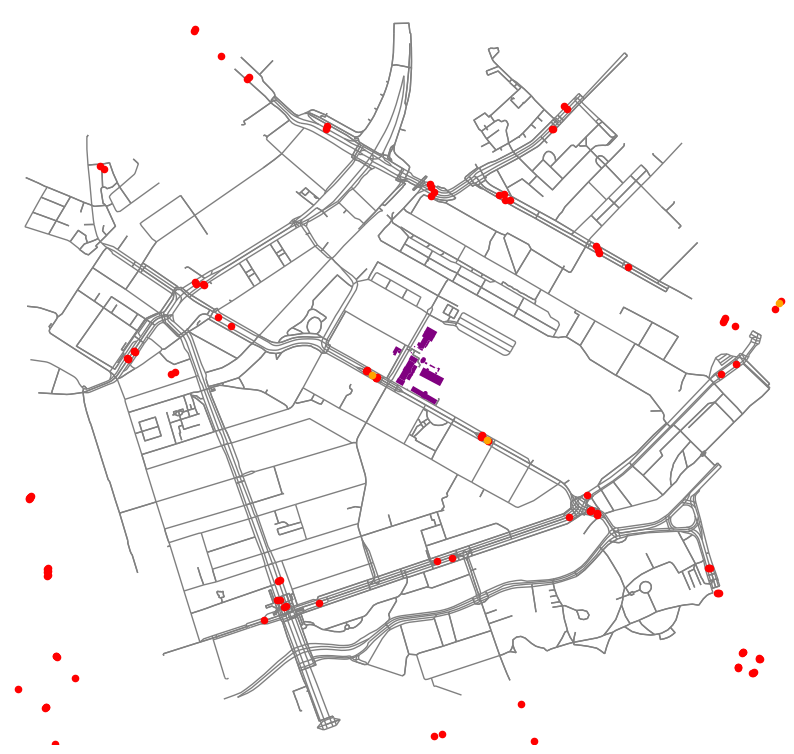

In [12]:
cityswim = ox.graph.graph_from_point(center, dist = 1300, network_type='all', dist_type='network')

north = float(avg_lat)+.1
south = float(avg_lat)-.1
west = float(avg_lon)-.1
east = float(avg_lon)+.1

edges_map = Polygon([(west, north), (east, north), (east, south), (west, south), (west, north)])
#water =ox.geometries.geometries_from_bbox(north, south, east, west, tags={'natural' : 'water'})
#water = water.clip(edges_map)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_facecolor('white')

ox.plot_graph(cityswim, edge_color='grey',
                        node_size=0,
                        show=False, close=False, ax=ax,)

gdf.plot(ax=ax, markersize = 20, color ="red") #closest bus stops
stops.plot(ax=ax, markersize = 20, color = "orange")
gdf1.plot(ax=ax, color = "purple") #We determine a 50m radius for the close buildings in order to ssign the HQ of the race.
#gdf2.plot(ax=ax, color = "dark green")
#water.plot(ax=ax, color="lightblue")

plt.savefig("publictransport.png")

We used the available data to find the capacity of public transport. We have 5 tram stops wihtin 1 km. The tram passes about 5-10 times and hour so averaging 7.5 times an hour. A tram has 60 seats and a 125 standing spaces [@(GVB, 2023; Wikipedia-bijdragers, 2022)]. The capacity of public transport is calculated below.

In [16]:
#Our endpoint and startpoint were assigned earlier as finish_swim and start_swim
#the center coordinates are calculated above as avg_lon, avg_lat

time_seconds = 10*60
speed = 4*1000/3600
wdistance = time_seconds * speed
print(wdistance)

#we calculate centrality for the street network around the swimming route and include the nodes at 666m distance. 
#we use network_type is all to include the bridges around Marine terrain

central_finish = ox.graph.graph_from_point(finish_swim, dist = wdistance, network_type='all')
central_start = ox.graph.graph_from_point(start_swim, dist = wdistance, network_type='all')

#find nearest nodes to the coordinates of the finish and headquarter
closest_finish = ox.distance.nearest_nodes(central_finish, df.longnum[16], df.latnum[16], return_dist=True)
print(closest_finish)

closest_start = ox.distance.nearest_nodes(central_start, df.longnum[0], df.latnum[0], return_dist=True)
print(closest_start)

centrality_finish = nx.closeness_centrality(central_finish, 46366390)
centrality_start = nx.closeness_centrality(central_start, 46365861)
print("The centrality of the finish is", centrality_finish, ", and the centrality of the start is", centrality_start)


666.6666666666667
(46366390, 6823208.798913781)
(46365861, 6823644.953020242)
The centrality of the finish is 0.0 , and the centrality of the start is 0.0390860200493787


#### The low numbers mean that the 'finish_swim' and 'start_swim' are easily accesible as a lower centrality number means the nodes are better connected.
